## CREDIT CARD DEPOSITS (Recruiting Task DataSet)
Please open the attached dataset. It is an anonymized sample of credit card deposit attempts over a 12-month period. It has been selected for analysis because it shows a longitudinally decreasing approval rate from 10/1/2020 to 9/26/2021.

PARAMETER DESCRIPTIONS

- Deposit attempts have a Appr? value of '1' or '0' signifying whether they have been approved or declined.
- CustomerID identifies the customer account attempting to deposit.
- Processing CO indicates the credit card processing company that is processing the transaction for the business.
- Issuing Bank indicates the bank that has issued the customer's credit card.
- Amount indicates the amount that the customer is attempting to deposit.
- Attempt Timestamp indicates the date and time of the deposit attempt.

QUESTIONS

1. What is the dataset's approval rate by quarter?
2. How many Processing COs failed to approve any deposit attempts in each of the four quarters?
3. Identify any factors likely to have played a causal role for the decline in approval rates seen in Q3 2021 vs Q4 2020? 

## imports

In [365]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

## load data from excel

In [145]:
cc_deposits = pd.read_excel('excel_files/Recruiting Task Dataset _ abridged version.xlsx')
columns = ['tx_approved?', 'customer_id', 'cc_processing_co', 'cc_bank', 'amount', 'datetime']
cc_deposits.columns = columns
cc_deposits = cc_deposits.set_index('datetime')
cc_deposits

,tx_approved?,customer_id,cc_processing_co,cc_bank,amount,datetime
0,1,154838,203,BANK1000,500.00,2021-09-26 23:56:00
1,1,154587,190,BANK1017,100.00,2021-09-26 23:53:00
2,0,143623,204,BANK1013,90.00,2021-09-26 23:46:00
3,1,154435,103,BANK1139,25.00,2021-09-26 23:38:00
4,0,155195,109,BANK1016,60.00,2021-09-26 23:29:00
...,...,...,...,...,...,...
124165,1,106214,125,BANK1000,41.00,2020-10-01 00:45:00
124166,1,101870,110,BANK1001,30.00,2020-10-01 00:36:00
124167,1,101628,124,BANK1002,25.00,2020-10-01 00:27:00
124168,0,113749,100,BANK1019,50.00,2020-10-01 00:25:00


## 1. What is the dataset's approval rate by quarter?

,datetime,total_tx,approved_tx,failed_tx,approval_rate
0,2020Q4,32372,20349,12023,62.86
1,2021Q1,34752,21366,13386,61.48
2,2021Q2,29075,17543,11532,60.34
3,2021Q3,27971,16621,11350,59.42


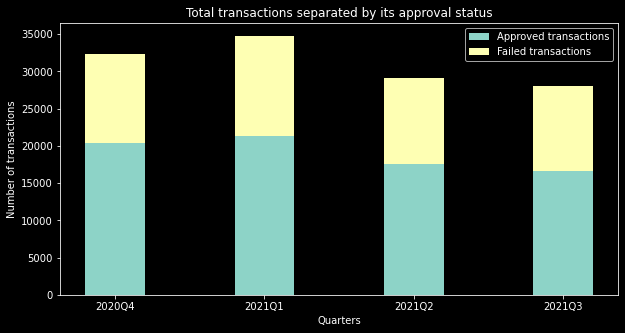

In [366]:
quarterly_approval_rate = cc_deposits.groupby(cc_deposits.index.to_period('Q'))['tx_approved?'].agg({'sum', 'count'})
quarterly_approval_rate['failed_tx'] = quarterly_approval_rate['count'] - quarterly_approval_rate['sum']
quarterly_approval_rate['approval_rate'] = (quarterly_approval_rate['sum'] / quarterly_approval_rate['count'] * 100).round(2)
quarterly_approval_rate = quarterly_approval_rate.reset_index().rename(columns={'count':'total_tx', 'sum':'approved_tx'})

display(quarterly_approval_rate)

fig, ax = plt.subplots(figsize = (10, 5))
x = list(quarterly_approval_rate.datetime.astype(str))
y1 = quarterly_approval_rate['approved_tx']
y2 = quarterly_approval_rate['failed_tx']
ax.bar(x, y1, width=0.4, align='center', label='Approved transactions')
ax.bar(x, y2, width=0.4, align='center', bottom=y1, label='Failed transactions')
ax.set_xlabel('Quarters')
ax.set_ylabel('Number of transactions')
ax.set_title('Total transactions separated by its approval status')
ax.legend()
plt.show()

## 2. How many Processing COs failed to approve any deposit attempts in each of the four quarters?

In [395]:
cc_processing_co_failure = cc_deposits.groupby([cc_deposits.index.to_period('Q'), 'cc_processing_co'])['tx_approved?'].value_counts().unstack().replace(np.nan, 0)
cc_processing_co_failure = cc_processing_co_failure.loc[cc_processing_co_failure[1] == 0].reset_index()
cc_processing_co_failure = cc_processing_co_failure.groupby('datetime')['cc_processing_co'].count().reset_index().rename(columns={'cc_processing_co':'cc_processing_co_failed_any'})
display(pd.DataFrame(cc_processing_co_failure))

,datetime,cc_processing_co_failed_any
0,2020Q4,7
1,2021Q1,7
2,2021Q2,6
3,2021Q3,7


## 3. Identify any factors likely to have played a causal role for the decline in approval rates seen in Q3 2021 vs Q4 2020?

### banks that fail the most

In [402]:
cc_bank_failure_analysis = cc_deposits.groupby('cc_bank')['tx_approved?'].value_counts().unstack().replace(np.nan, 0)
cc_bank_failure_analysis['total_tx'] = cc_bank_failure_analysis[0] + cc_bank_failure_analysis[1]
cc_bank_failure_analysis['failure_rate'] = cc_bank_failure_analysis[0] / cc_bank_failure_analysis['total_tx'] * 100
cc_bank_failure_analysis = cc_bank_failure_analysis.sort_values(by=[0, 'failure_rate', 'total_tx'], ascending=False)
cc_bank_failure_analysis.head(15)

tx_approved?,0,1,total_tx,failure_rate
cc_bank,,,,
BANK1000,7537.0,15747.0,23284.0,32.369868
BANK1013,4337.0,4449.0,8786.0,49.362622
BANK1001,4007.0,8399.0,12406.0,32.298888
BANK1002,3117.0,8934.0,12051.0,25.865073
BANK1017,2602.0,3042.0,5644.0,46.102055
BANK1029,1925.0,578.0,2503.0,76.907711
BANK1004,1412.0,1842.0,3254.0,43.392747
BANK1006,1244.0,2445.0,3689.0,33.721876
BANK1019,1152.0,2051.0,3203.0,35.966282


### processing companies that fail the most

In [403]:
cc_processing_co_failure_analysis = cc_deposits.groupby('cc_processing_co')['tx_approved?'].value_counts().unstack().replace(np.nan, 0)
cc_processing_co_failure_analysis['total_tx'] = cc_processing_co_failure_analysis[0] + cc_processing_co_failure_analysis[1]
cc_processing_co_failure_analysis['failure_rate'] = cc_processing_co_failure_analysis[0] / cc_processing_co_failure_analysis['total_tx'] * 100
cc_processing_co_failure_analysis = cc_processing_co_failure_analysis.sort_values(by=[0, 'failure_rate', 'total_tx'], ascending=False)
cc_processing_co_failure_analysis.head(15)

tx_approved?,0,1,total_tx,failure_rate
cc_processing_co,,,,
111,2908.0,6238.0,9146.0,31.795320
182,2783.0,3038.0,5821.0,47.809655
103,2350.0,4341.0,6691.0,35.121805
143,2315.0,0.0,2315.0,100.000000
120,2133.0,2049.0,4182.0,51.004304
166,1752.0,1481.0,3233.0,54.191154
112,1368.0,3442.0,4810.0,28.440748
203,1233.0,2990.0,4223.0,29.197253
122,1231.0,3124.0,4355.0,28.266361


## other calculations

In [396]:
prueba = cc_deposits.groupby(['cc_bank', 'cc_processing_co'])['tx_approved?'].value_counts().unstack().replace(np.nan, 0)
prueba['total_tx'] = prueba[0] + prueba[1]
prueba['failure_rate'] = prueba[0] / prueba['total_tx'] * 100
prueba = prueba.sort_values(by=[0, 'failure_rate', 'total_tx'], ascending=False)
#prueba = cc_bank_failure_analysis.sort_values(by=[0], ascending=False)
#prueba = cc_bank_failure_analysis.sort_values(by=['failure_rate', 'total_tx'], ascending=False)
prueba.head(15)

tx_approved?                   0       1  total_tx  failure_rate
cc_bank  cc_processing_co                                       
BANK1000 103               594.0  1363.0    1957.0     30.352580
         182               528.0   734.0    1262.0     41.838352
         111               517.0  1424.0    1941.0     26.635755
BANK1013 111               331.0   385.0     716.0     46.229050
BANK1000 120               325.0   269.0     594.0     54.713805
         122               281.0   669.0     950.0     29.578947
BANK1013 182               278.0   205.0     483.0     57.556936
BANK1000 143               271.0     0.0     271.0    100.000000
BANK1001 111               260.0   567.0     827.0     31.438936
BANK1000 100               248.0  1044.0    1292.0     19.195046
         106               239.0   253.0     492.0     48.577236
         166               233.0   128.0     361.0     64.542936
BANK1013 120               215.0   162.0     377.0     57.029178
BANK1001 182               209.0   316.0     525.0     39.809524
         103               208.0   395.0     603.0     34.494196

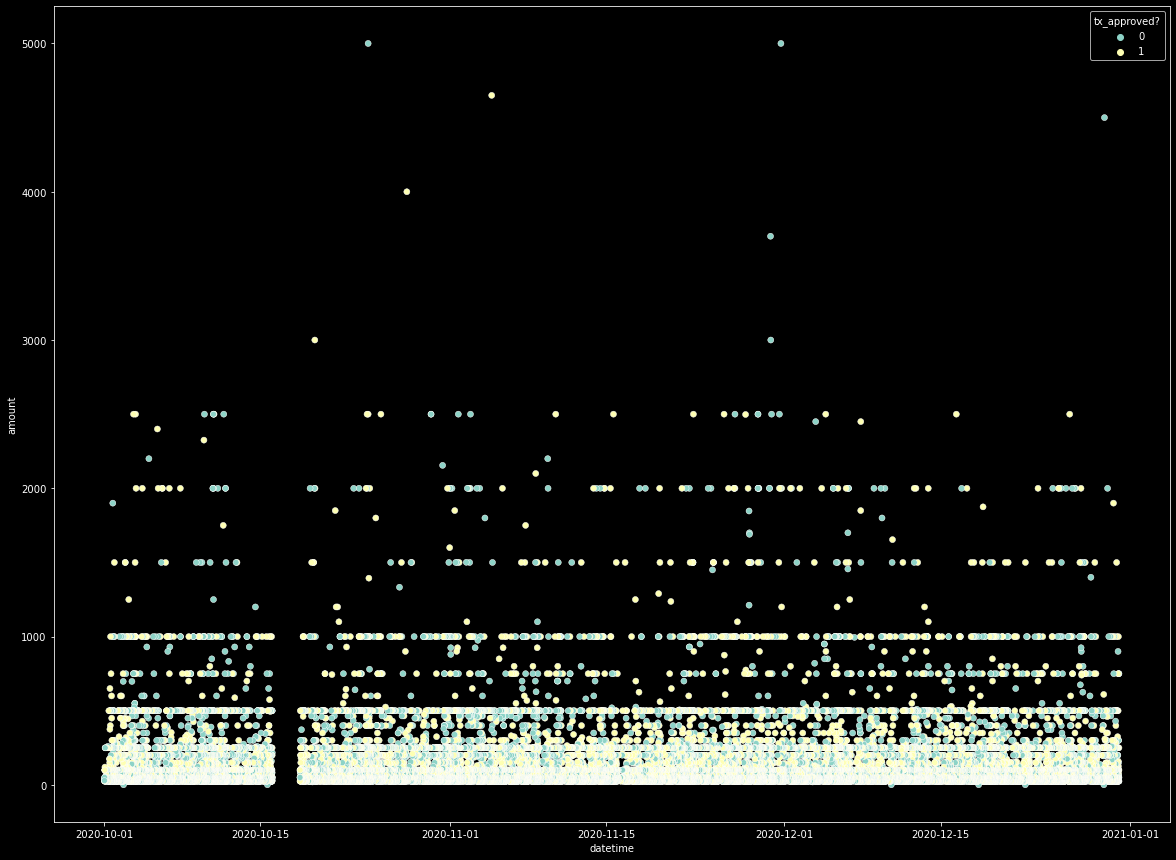

In [401]:
q4_2020_start_date = pd.Timestamp('2020-10-01')
q4_2020_end_date = pd.Timestamp('2020-12-31')
q4_2020_cc_deposits = cc_deposits.loc[(cc_deposits.index >= q4_2020_start_date) & (cc_deposits.index <= q4_2020_end_date)]

q3_2021_start_date = pd.Timestamp('2021-07-01')
q3_2021_end_date = pd.Timestamp('2021-09-30')
q3_2021_cc_deposits = cc_deposits.loc[(cc_deposits.index >= q3_2021_start_date) & (cc_deposits.index <= q3_2021_end_date)]

fig, ax = plt.subplots(figsize = (20, 15))
sns.scatterplot(data=q4_2020_cc_deposits, x='datetime', y='amount', hue='tx_approved?');

,datetime,unique_count_failed_pco,unique_count_total_pco,failed_rate_unique_pco,unique_count_approved_pco
0,2020Q4,57,57,100.00,0
1,2021Q1,90,92,97.83,2
2,2021Q2,81,82,98.78,1
3,2021Q3,77,77,100.00,0


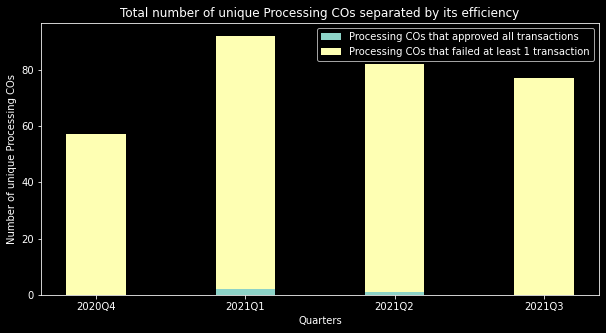

In [404]:
quarterly_approval_failed_by_pco = cc_deposits.loc[cc_deposits['tx_approved?'] == 0]
quarterly_approval_failed_by_pco = pd.DataFrame(quarterly_approval_failed_by_pco.groupby(quarterly_approval_failed_by_pco.index.to_period('Q'))['cc_processing_co'].nunique())

quarterly_approval_total_by_pco = cc_deposits.groupby(cc_deposits.index.to_period('Q'))['cc_processing_co'].nunique()

quarterly_approval_failed_by_pco['unique_count_total_pco'] = quarterly_approval_total_by_pco
quarterly_approval_failed_by_pco['failed_rate_unique_pco'] = (quarterly_approval_failed_by_pco['cc_processing_co'] / quarterly_approval_failed_by_pco['unique_count_total_pco'] * 100).round(2)

quarterly_approval_failed_by_pco = quarterly_approval_failed_by_pco.reset_index().rename(columns={'cc_processing_co':'unique_count_failed_pco'})

quarterly_approval_failed_by_pco['unique_count_approved_pco'] = quarterly_approval_failed_by_pco['unique_count_total_pco'] - quarterly_approval_failed_by_pco['unique_count_failed_pco']
display(quarterly_approval_failed_by_pco)

fig, ax = plt.subplots(figsize = (10, 5))
x = list(quarterly_approval_failed_by_pco.datetime.astype(str))
y1 = quarterly_approval_failed_by_pco['unique_count_approved_pco']
y2 = quarterly_approval_failed_by_pco['unique_count_failed_pco']
ax.bar(x, y1, width=0.4, align='center', label='Processing COs that approved all transactions')
ax.bar(x, y2, width=0.4, align='center', bottom=y1, label='Processing COs that failed at least 1 transaction')
ax.set_xlabel('Quarters')
ax.set_ylabel('Number of unique Processing COs')
ax.set_title('Total number of unique Processing COs separated by its efficiency')
ax.legend()
plt.show()